# SABR Volatility Model

## Reference from QuantExchange:
* [SABR Implied Volatility and Option Prices](https://quant.stackexchange.com/questions/21462/sabr-implied-volatility-and-option-prices)
* [What are the advantages/disadvantages of these approaches to deal with volatility surface?](https://quant.stackexchange.com/questions/5981/what-are-the-advantages-disadvantages-of-these-approaches-to-deal-with-volatilit)
* [What is the importance of alpha, beta, rho in the SABR volatility model?](https://quant.stackexchange.com/questions/39849/what-is-the-importance-of-alpha-beta-rho-in-the-sabr-volatility-model)
*[Calibrate a SABR model?](https://quant.stackexchange.com/questions/43341/calibrate-a-sabr-model)

## What is SABR?
Alpha, Beta and Rho are the point of the model. So explaining them is explaining the model.

## A model of two processes
Unlike earlier models in which the volatility was modelled as a constant (Vasicek, Hull-White, etc), SABR assumes that as well as the price of the thing being stochastic, so is its volatility. That is, the volatility will also follow some stochastic path.

Thus we have two clearly related processes; the price, lets say of a forward rate (following the Wikipedia notation):

dFt=σtFβtdWt

Which just means the changes in the price are proportional to the price itself raised to power β, and a Wiener process Wt, scaled by the now time-dependent volatility σt.

We also have a process for the volatility σt:

dσt=ασtdZt

Again, the changes in volatility are proportional to the volatility itself (so the behaviour is scale invariant) and to a second Wiener process Zt, all scaled this time by α.

α is then the (constant) volatility of the volatility. I mean, we could model that as stochastic too but that seems like hard work.

## So where is ρ?
α was the volvol, β was the power in the price relation, we are missing ρ.

Since the two processes (the price and its volatility) are very much related, the SABR model connects the two Wiener processes driving their movement by making them correlated with parameter ρ:

dWtdZt=ρdt

So changes in the two Wiener processes are correlated with ρ in time. Again, ρ is a constant.

So none of α, β or ρ are stochastic; perhaps the name should have been Stochastic Volatility, Alpha Beta Rho. But SVABR is much less catchy.

## How am I going to price anything with SABR when no one quotes α/β/ρ?
Ah yes. While the market does quote volatilities, it doesn't quote these parameters, so it's hard to just knit a model in Excel and wear it.

The equations we have so far model the dynamics given the parameters, so in order to get the parameters we will have to essentially solve for the parameters given some other stuff, like market prices for options which are sensitive to those parameters.

Calibrating a set of parameter values to market quotes is the subject of much effort, e.g. this blog post.

## All models are finite
No model is able to magically capture all the information available, and there would be no point; a model's power is in deriving simpler truths than the information you start with. With SABR the model better recreates the dynamics of the evolution of an interest rate, but note that there are just a small, fixed number of parameters. So it cannot calibrate perfectly to a market with tens or hundreds of inputs.

### Local Volatility Model:

* Advantage:
    * Fast and exact calibration to the volatility surface.
    * Suitable for products which **only depend on terminal distribution** of the underlying (no "conditional properties").
* Disadvantage:
    * Not suitable for more complex products which depend heavily on "conditional properties", like barrier options.

### Stochastic Volatility Model:

* Advantage:
    * Can produce more realistic dynamics, e.g. forward volatility.
    * Can produce more realistic hedge dynamics.
* Disadvantage: 
    * For products which depend only on **terminal** distributions the fit of the volatility surface may be too poor, like european options

\begin{align}
  & d{{f}_{t}}={{\alpha }_{t}}f_{t}^{\beta }d{{W}_{t}}^{1} \\ 
 & d{{\alpha }_{t}}=v\,{{\alpha }_{t}}d{{W}_{t}}^{2} \\ 
 & {{E}^{Q}}[d{{W}_{t}}^{1},d{{W}_{t}}^{2}]=\rho dt \\ 
\end{align}

# Aim

1. Given an example of volatiltiy surface, **calibrate** a SABR model.
2. Do the same for different maturities.
3. Plot a 3D surface.
4. Use the model to price a swaption/option.

# Step 1: Estimate beta ($\beta$)

* β=0 produces the stochastic normal model, 
* β=1 produces the stochastic log-normal model
* β=1/2 produces the stochastic CIR model.

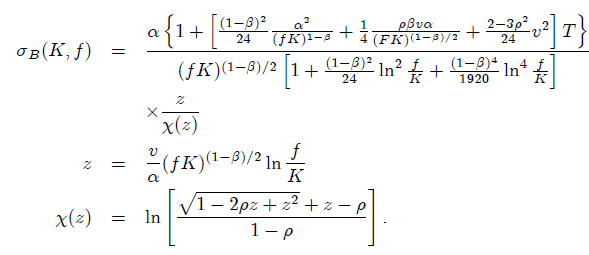

The at-the-money volatility σATM is obtained by setting f=K in equation σ(K,β), which produces:

$${{\sigma }_{ATM}}={{\sigma }_{\beta }}(f,f)=\frac{\alpha \left( 1+\left[ \frac{{{(1-\beta )}^{2}}}{24}\times \frac{{{\alpha }^{2}}}{{{f}^{2-2\beta }}}+\frac{1}{4}\frac{\rho \beta v\alpha }{{{f}^{1-\beta }}}+\frac{2-3{{\rho }^{2}}}{24}{{v}^{2}} \right]T \right)}{{{f}^{1-\beta }}}$$

$$\ln {{\sigma }_{ATM}}\approx \ln \alpha -(1-\beta )\ln f$$

In [233]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import datetime
from scipy.optimize import minimize, rosen, rosen_der

In [304]:
def sabr_vol(alpha, beta, rho, volvol, f, K, T):
    # α is the initial variance
    # β is the exponent for the forward rate,
    # v is the volatility of variance,
    # rho is the correlation of two brownion motions.
    if f != K:
        n_first_term_1 = (1 - beta)**2/24
        n_first_term_2 = (alpha**2)/((f * K)**(1 - beta))
        n_second_term_1 = 0.25 * rho * beta * volvol * alpha
        n_second_term_2 = (f * K)**(0.5 * (1 - beta))
        n_third_term    = (2 - 3 * rho**2) * volvol**2/24
        d_first_term    = (f * K)**(0.5 * (1 - beta))
        d_second_term    = (1 - beta)**2/24 * (np.log(f/K))**2
        d_third_term    = (1 - beta)**4/1920 * (np.log(f/K))**4
        z = volvol/alpha*(f * K)**((1 - beta)/2) * np.log(f/K)
        chi_x = np.log((np.sqrt(1-2*rho*z+z**2) + z - rho)/(1 - rho))
        
        nominator = alpha * (1 + (n_first_term_1 * n_first_term_2 + n_second_term_1/n_second_term_2 + n_third_term) * T)
        denominator = d_first_term * (1 + d_second_term + d_third_term)
        output = nominator/denominator * z/chi_x
    else:
        n_first_term_1 = (1 - beta)**2/24
        n_first_term_2 = (alpha**2)/(f**(2 - 2 * beta))
        n_second_term_1 = 0.25 * rho * beta * volvol * alpha
        n_second_term_2 = f**(1 - beta)
        n_third_term    = (2 - 3 * rho**2) * volvol**2/24
        nominator = alpha * (1 + (n_first_term_1 * n_first_term_2 + n_second_term_1/n_second_term_2 + n_third_term) * T)
        denominator = f**(1 - beta)
        output = nominator/denominator
        
    return output

def delta_to_strike(f, delta, vol, T):
    output = f * np.exp(norm.ppf(delta)* vol * np.sqrt(T) + 0.5 * vol**2 * T)
    return output
    

In [305]:
# Config:

initial_spot= 100

# Create a volatility surface with delta and maturity
# The sequence should be: 25D Call, 35D Call, ATM, 35D Put, 25D Put
volsurface = pd.DataFrame(np.array([['2-Sep-2020', '8-Sep-2020', '15-Sep-2020', '22-Sep-2020', '1-Oct-2020', '1-Nov-2020','1-Dec-2020','1-Mar-2021', '1-Jun-2021', '1-Sep-2021'],                       
                       ['ON', '1W', '2W', '3W', '1M', '2M', '3M', '6M', '9M', '1Y'],                     
                       [16.619, 16.855, 14.664, 13.548, 12.488, 12.365, 12.166, 10.650, 10.020, 8.885],
                       [16.670, 17.005, 14.862, 13.789, 12.788, 12.585, 12.388, 10.850, 10.150, 8.952],
                       [16.915, 17.335, 15.267, 14.243, 13.320, 13.150, 12.500, 11.350, 10.370, 9.000],
                       [17.320, 17.805, 15.832, 14.886, 14.043, 13.485, 12.687, 11.587, 10.685, 9.150],
                       [17.786, 18.255, 16.361, 15.483, 14.723, 13.875, 12.985, 11.785, 10.985, 9.200]]).T,    
                   columns=['expiry_date', 'tenor', 'vol_25', 'vol_35', 'vol_50', 'vol_65', 'vol_75'])

delta_col_list = np.array(volsurface.columns[volsurface.columns.str.contains('vol')])
delta_list = np.array(volsurface.columns[volsurface.columns.str.contains('vol')].str.replace("vol_", "")).astype(int)
volsurface['t'] = (pd.to_datetime(volsurface_['expiry_date'], format="%d-%b-%Y") - pd.to_datetime("1-Sep-2020", format="%d-%b-%Y")).astype('timedelta64[D]').astype(int)/252

val = {}
for i in range(0, len(volsurface)):
    maturity = volsurface.loc[i]
    strike_list = np.array(list(map(lambda x:delta_to_strike(initial_spot, float(x)/100, float(maturity['vol_' + str(x)])/100, maturity.t), delta_list)))
    def obj_func(par):
        # Par as a list storing alpha, rho, and volvol.
        sabr_predicted_vol = np.array(list(map(lambda x: sabr_vol(par[0], beta, par[1], par[2], initial_spot, x, maturity.t), strike_list)))
        true_vol = np.array(maturity[delta_col_list].astype(float).tolist())/100
        sum_mse = np.sum((sabr_predicted_vol - true_vol)**2)
        return sum_mse
    res = minimize(obj_func, x0 = (0.1, 0.5, 0.15), method='SLSQP', bounds=[(0.0001, None), (-0.9999, 0.9999), (0.0001, None)])
    val[i] = {'alpha': res.x[0], 'rho': res.x[1], 'volvol': res.x[2]}


In [314]:
volsurface_ = pd.merge(volsurface, pd.DataFrame(val).T, left_index=True, right_index=True)

In [315]:
volsurface_

,expiry_date,tenor,vol_25,vol_35,vol_50,vol_65,vol_75,t,alpha,rho,volvol
0,2-Sep-2020,ON,16.619,16.67,16.915,17.32,17.786,0.003968,0.170612,0.500002,0.150010
1,8-Sep-2020,1W,16.855,17.005,17.335,17.805,18.255,0.027778,0.174472,0.500009,0.150043
2,15-Sep-2020,2W,14.664,14.862,15.267,15.832,16.361,0.055556,0.153906,0.500012,0.150057
3,22-Sep-2020,3W,13.548,13.789,14.243,14.886,15.483,0.083333,0.143806,0.500015,0.150069
4,1-Oct-2020,1M,12.488,12.788,13.32,14.043,14.723,0.119048,0.134599,0.500018,0.150081
5,1-Nov-2020,2M,12.365,12.585,13.15,13.485,13.875,0.242063,0.130723,0.500017,0.150092
6,1-Dec-2020,3M,12.166,12.388,12.5,12.687,12.985,0.361111,0.125209,0.500009,0.150072
7,1-Mar-2021,6M,10.65,10.85,11.35,11.587,11.785,0.718254,0.111972,0.500014,0.150081
8,1-Jun-2021,9M,10.02,10.15,10.37,10.685,10.985,1.083333,0.103749,0.500008,0.150042
9,1-Sep-2021,1Y,8.885,8.952,9.0,9.15,9.2,1.448413,0.089462,0.499991,0.149915


In [ ]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

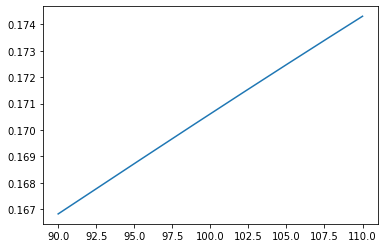

In [326]:
strikes = np.linspace(90, 110, 1000)
vol_sabr = list(map(lambda x: sabr_vol(volsurface_.loc[0].alpha, 1, volsurface_.loc[0].rho, volsurface_.loc[0].volvol, initial_spot, x, volsurface_.loc[0].t), strikes))
plt.plot(strikes,vol_sabr,zorder=1)
plt.scatter(dates,values)